A:
     θ0   θ1   θ2   θ3   θ4   θ5
q0  1.0  0.0  0.0  0.0  0.0  0.0
q1 -1.0  1.0  0.0  0.0  0.0  0.0
q2  0.0 -1.0  1.0  0.0  0.0  0.0
q3  0.0  0.0 -1.0  1.0  0.0  0.0
q4  0.0  0.0  0.0 -1.0  1.0  0.0
q5  0.0  0.0  0.0  0.0  0.0  1.0
q6  0.0  0.0  0.0  0.0 -1.0  1.0
q7  0.0  0.0  0.0  0.0  0.0  1.0 

G:
q0     2890.5000
q1     1618.6800
q2     1618.6800
q3       78.0435
q4       78.0435
q5    36004.3590
q6      924.9600
q7     1000.0000
dtype: float64 

C:
θ0           0.00
θ1    46802976.00
θ2           0.00
θ3      615560.88
θ4           0.00
θ5       72000.00
dtype: float64 

b:
q0       To
q1        0
q2        0
q3        0
q4        0
q5       To
q6        0
q7    Ti_sp
dtype: object 

f:
θ0    Φo
θ1     0
θ2     0
θ3     0
θ4    Φi
θ5    Qa
dtype: object 

y:
θ0    0.0
θ1    0.0
θ2    0.0
θ3    0.0
θ4    0.0
θ5    1.0
dtype: float64 

θss = [10.   10.01 10.02 10.14 10.26 10.27] °C
θssQ = [0.03 0.09 0.15 1.37 2.6  2.7 ] °C
uss = [10 10 20  0  0  0]
yss = 10.27 °C
Error between DA

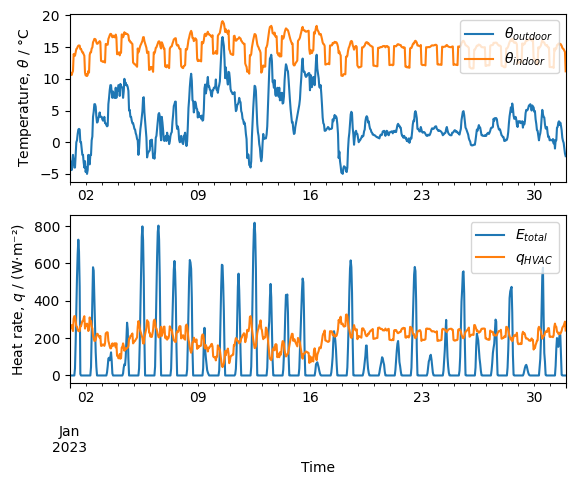

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dm4bem
from dm4bem import *

import time

# MODELLING
# ==============
## Building properties
l = 4                   # m length 
L = 5
height = 3               # m height of the walls
Sw = 1.30**2       # m² surface area of one window
Sd =  1* 1          # m² surface area of the door
Sc = Si =  6 * l * L - 2*Sw - Sd   # m² surface area of concrete & insulation of the walls
S = Sc + Sd + Sw * 2     # total surface area of the 4 sides of the building

## Thermophysical properties

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

concrete = {'Conductivity': 1.400,          # W/(m·K)
            'Density': 2300.0,              # kg/m³
            'Specific heat': 880,           # J/(kg⋅K)
            'Width': 0.2,                   # m
            'Surface': Sc}                  # m²

insulation = {'Conductivity': 0.027,        # W/(m·K)
              'Density': 55.0,              # kg/m³
              'Specific heat': 1210,        # J/(kg⋅K)
              'Width': 0.08,                # m
              'Surface': Sc}                # m²

glass = {'Conductivity': 2.8,               # W/(m²·K) - https://www.gov.scot/binaries/content/documents/govscot/publications/advice-and-guidance/2020/02/tables-of-u-values-and-thermal-conductivity/documents/6-a---tables-of-u-values-and-thermal-conductivity/6-a---tables-of-u-values-and-thermal-conductivity/govscot%3Adocument/6.A%2B-%2BTables%2Bof%2BU-values%2Band%2Bthermal%2Bconductivity%2B%2B.pdf
         'Density': 2500,                   # kg/m³
         'Specific heat': 1210,             # J/(kg⋅K)
         'Width': 1,                        # m - 1m because m² at conductivity
         'Surface': Sw}                     # m²

wood = {'Conductivity': 0.14,               # W/(m·K) - https://materials.ads.org.uk/larch/
         'Density': 500,                    # kg/m³ - Larch wood; EngineeringToolbox.com
         'Specific heat': 1500,             # J/(kg⋅K) - Larch wood; https://web.ornl.gov/sci/buildings/conf-archive/1992%20B5%20papers/028.pdf#:~:text=URL%3A%20https%3A%2F%2Fweb.ornl.gov%2Fsci%2Fbuildings%2Fconf
         'Width': 0.05,                     # m
         'Surface': Sd}                     # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass, 
                               'Wood': wood},
                              orient='index')



# Convection coefficient
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

###
### Thermal Network

#Ventilation flow rate
ACH = 0.5           # 1/h closed door and windows
Va = l*L*height                   # m³, volume of air
Va_dot = ACH*3600/Va

# CONDUCTANCES W/K
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns=['Conductance'])

Uwin = 1.1        # W/m2K U for both windows with double glazing, conduction and convection
Ud = 2.5        # W/m2K U for the door, conduction and convection
Gventi = air['Density'] * air['Specific heat'] * Va_dot
Gdoor = Ud*Sd
Gwin = Uwin*Sw
Geq = Gventi + Gdoor + Gwin 

# Convection
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
G_conv = h * wall['Surface'].iloc[0]     # wall

# P-controler gain
Kp = 1e3            # almost perfect controller Kp -> ∞
# Kp = 1e-3           # no controller Kp -> 0
# Kp = 0  

## Thermal capacities
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
pd.DataFrame(C, columns=['Capacity'])

C['Air'] = air['Density'] * air['Specific heat'] * Va
pd.DataFrame(C, columns=['Capacity'])

## MATRICES 

# temperature nodes
θ = ['θ0', 'θ1', 'θ2', 'θ3', 'θ4', 'θ5']

# flow-rate branches
q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7']

A = np.zeros([8, 6])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 3], A[4, 4] = -1, 1    # branch 4: node 3 -> node 4
A[5, 5] =  1                # branch 5: -> node 5
A[6, 4], A[6, 5] = -1, 1    # branch 6: node 4 -> node 5
A[7, 5] = 1                 # branch 7: -> node 5

pd.DataFrame(A, index=q, columns=θ)


G = np.array(np.hstack(
    [G_conv['out'],
     2 * G_cd['Layer_out'], 2 * G_cd['Layer_out'],
     2 * G_cd['Layer_in'], 2 * G_cd['Layer_in'],
     Geq,
     G_conv['in'],
     Kp]))
pd.DataFrame(G, index=q)

# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

C = np.array([0, C['Layer_out'], 0, C['Layer_in'], 0,
                  C['Air']])

b = pd.Series(['To', 0, 0, 0, 0, 'To',0, 'Ti_sp'],
              index=q)

f = pd.Series(['Φo', 0, 0, 0, 'Φi', 'Qa'],
              index=θ)

y = np.zeros(6)         # nodes
y[[5]] = 1              # nodes (temperatures) of interest
pd.DataFrame(y, index=θ)

# thermal circuit
A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(G, index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}

TC['G']['q7'] = 1e3  #car controller

dm4bem.print_TC(TC)

# STEADY STATE STUDY
# =======================

controller = False
neglect_air_glass_capacity = False

# by default TC['G']['q7'] = 0, i.e. Kp -> 0, no controller (free-floating)
if controller:
    TC['G']['q7'] = 1e3        # Kp -> ∞, almost perfect controller

# by default TC['G']['q7'] = 0, i.e. Kp -> 0, no controller (free-floating)
        # Kp -> ∞, almost perfect controller

if neglect_air_glass_capacity:
    TC['C']['θ6'] = TC['C']['θ7'] = 0
    # or
    TC['C'].update({'θ6': 0, 'θ7': 0})
# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

bss = np.zeros(8)        # temperature sources b for steady state
bss[[0, 5]] = 10      # outdoor temperature
bss[[7]] = 20            # indoor set-point temperature

fss = np.zeros(6)         # flow-rate sources f for steady state
A = TC['A']
G = TC['G']
diag_G = pd.DataFrame(np.diag(G), index=G.index, columns=G.index)

θss = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θss = {np.around(θss, 2)} °C')
bss = np.zeros(8)        # temperature sources b for steady state

fss = np.zeros(6)         # flow-rate sources f for steady state
fss[[5]] = 100000

θssQ = np.linalg.inv(A.T @ diag_G @ A) @ (A.T @ diag_G @ bss + fss)
print(f'θssQ = {np.around(θssQ, 2)} °C')
bT = np.array([10, 10, 20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0])         # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])           # input vector for state space
print(f'uss = {uss}')

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yss = (-Cs @ inv_As @ Bs + Ds) @ uss

yss = float(yss.values[0])
print(f'yss = {yss:.2f} °C')

print(f'Error between DAE and state-space: {abs(θss[5] - yss):.2e} °C')

bT = np.array([0, 0, 0])         # [To, To, To, Tisp]
fQ = np.array([0, 0, 100000])      # [Φo, Φi, Qa, Φa]
uss = np.hstack([bT, fQ])

inv_As = pd.DataFrame(np.linalg.inv(As),
                      columns=As.index, index=As.index)
yssQ = (-Cs @ inv_As @ Bs + Ds) @ uss

yssQ = float(yssQ.values[0])
print(f'yssQ = {yssQ:.2f} °C')

print(f'Error between DAE and state-space: {abs(θssQ[5] - yssQ):.2e} °C')


### INPUTS
# ==============
#filename = './weather_data/FRA_AR_Grenoble.074850_TMYx.epw'
filename = './FRA_AR_Grenoble.Alpes.Isere.AP.074860_TMYx.2007-2021.epw'


[data, meta] = read_epw(filename, coerce_year=None)
data

# Extract the month and year from the DataFrame index with the format 'MM-YYYY'
month_year = data.index.strftime('%m-%Y')

# Create a set of unique month-year combinations
unique_month_years = sorted(set(month_year))

# Create a DataFrame from the unique month-year combinations
pd.DataFrame(unique_month_years, columns=['Month-Year'])

# select columns of interest
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad",]]

# replace year with 2023 in the index 
weather_data.index = weather_data.index.map(
    lambda t: t.replace(year=2023))

#print(weather_data.loc['2000-06-29 12:00'])

# Define start and end dates
start_date = '2023-01-01 00:00'
end_date = '2023-12-31 23:00'         # time is 00:00 if not indicated

# Filter the data based on the start and end dates
donne = weather_data.loc[start_date:end_date]
print (donne)

######### TEMPERATURES SOURCES ##########

weather = weather_data.loc[start_date:end_date]
To = weather['temp_air']

# indoor air temperature set-point
Ti_sp = pd.Series(20, index=To.index)

Ti_day, Ti_night = 20, 16

Ti_sp = pd.Series(
    [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
    index=To.index)

######### HEAT SOURCES ##########

## Orientation du mur ##
surface_orientation = {'slope': 90,     # 90° is vertical; > 90° downward
                       'azimuth': 45,    # 0° South, positive westward
                       'latitude': 45.19}  # °, North Pole 90° positive

albedo = 0.3

rad_surf = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)

Etot = rad_surf.sum(axis=1)

# window glass properties
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# Outdoor wall surface
α1 = 0.25       # short wave absorbtivity indoor white walls
α2 = 0.30       # short wave absorbtivity indoor walls

# solar radiation absorbed by the outdoor surface of the wall
Φo = α2 * Sc * Etot

# solar radiation absorbed by the indoor surface of the wall
Φi = τ_gSW * α1 * Sw*2 * Etot

# auxiliary (internal) sources
Qa = 0 * np.ones(weather.shape[0])

# Input data set
input_data_set = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                               'Φo': Φo, 'Φi': Φi, 'Qa': Qa,
                               'Etot': Etot})

#### SIMULATION
# ==============
controller = True
Kp = 1e3    # W/°C, controller gain


explicit_Euler = False

imposed_time_step = True
Δt = 3600    # s, imposed time step 

# MODEL
# =====
# Thermal circuits
dm4bem.print_TC(TC)

# by default TC['G']['q7'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q7'] = Kp*1e2     # G7 = Kp, conductance of edge q7
                            # Kp -> ∞, almost perfect controller

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)

# INPUT DATA SET
# ==============
input_data_set

input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')

# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

# Initial conditions
θ0 = 20.0  # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0  # fill θ with initial values θ0

I = np.eye(As.shape[0])  # identity matrix

# Kp = TC['G']['q7']  # controller gain

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0]):
        # Update state using implicit Euler
        θ.iloc[k] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])

# Outputs
y = (Cs @ θ.T + Ds @  u.T).T

S = 5*4                   # m², surface area of the building
q_HVAC = Kp * (u['q7'] - y['θ5']) / S  # W/m²

data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ5'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

fig, axs = plt.subplots(2, 1)
data[['To', 'θi']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show()